## **Predicting House Price by Size, Location and Neighbourhood.**

In [5]:
# pip install category-encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.1 MB/s eta 0:00:00


Importing the category-encoders for the selected features that are categorical like neighborhood.

In [13]:
from google.colab import files
import pandas as pd

# This part uploads the file
uploaded = files.upload()

# This part finds the name of the uploaded file and reads it into a pandas DataFrame
# Assuming you uploaded only one file and it's a CSV
for filename in uploaded.keys():
  df = pd.read_csv(filename)
  print(f"File '{filename}' loaded into DataFrame.") # Optional: confirm load

# Now you can work with the 'df' DataFrame
print(df.head()) # Display the first few rows to check

Saving buenos-aires-real-estate-1.csv to buenos-aires-real-estate-1 (3).csv
Saving buenos-aires-real-estate-2.csv to buenos-aires-real-estate-2 (2).csv
File 'buenos-aires-real-estate-1 (3).csv' loaded into DataFrame.
File 'buenos-aires-real-estate-2 (2).csv' loaded into DataFrame.
  operation property_type                            place_with_parent_names  \
0      sell            PH   |Argentina|Bs.As. G.B.A. Zona Norte|Tigre|Tigre|   
1      sell         house  |Argentina|Bs.As. G.B.A. Zona Norte|Tigre|Bena...   
2      sell     apartment               |Argentina|Capital Federal|Recoleta|   
3      sell         house  |Argentina|Bs.As. G.B.A. Zona Oeste|Tres de Fe...   
4      sell     apartment  |Argentina|Bs.As. G.B.A. Zona Oeste|Tres de Fe...   

                   lat-lon     price currency  price_aprox_local_currency  \
0  -34.4281108,-58.5728848  160000.0      USD                   2425984.0   
1                      NaN  270000.0      USD                   4093848.0   
2  -34

Importing the dataset into the notebook.

In [37]:
# Importing Necessary Libraries
# from glob import glob

# Step 1: Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# from category_encoders import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge  # noqa F401
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from category_encoders.one_hot import OneHotEncoder  # from `category_encoders`
from sklearn.metrics import mean_absolute_error



Importing necessary libraries.

### Preparing the Dataset

In [26]:
def wrangle(filepath):
    import pandas as pd

    # Read CSV file
    df = pd.read_csv(filepath)

    # Subset data: Apartments in "Capital Federal", price less than 400,000 USD
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal", na=False)
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 400_000
    df = df[mask_ba & mask_apt & mask_price]

    # Remove outliers in surface area
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Extract lat and lon
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)

    # Drop rows where lat/lon is missing
    df.dropna(subset=["lat", "lon"], inplace=True)

    # Extract neighborhood
    df["neighborhood"] = df["place_with_parent_names"].str.split("|", expand=True)[3]
    df.drop(columns="place_with_parent_names", inplace=True)

    # Drop columns with too many null values
    df.drop(columns=["floor", "expenses"], inplace=True)

    # Drop features with high/low cardinality that aren't useful
    df.drop(columns=["operation", "property_type", "currency", "properati_url"], inplace=True)

    # Drop leaky features (derived from target)
    df.drop(columns=[
        "price",
        "price_aprox_local_currency",
        "price_per_m2",
        "price_usd_per_m2"
    ], inplace=True)

    # Drop multicollinear or redundant features
    df.drop(columns=["surface_total_in_m2", "rooms"], inplace=True)

    return df





In [28]:
frames = [wrangle(file) for file in uploaded]
frames[0].head()

,price_aprox_usd,surface_covered_in_m2,lat,lon,neighborhood
4,129000.0,70.0,-34.584651,-58.454693,Chacarita
9,87000.0,42.0,-34.638979,-58.500115,Villa Luro
29,118000.0,54.0,-34.615847,-58.459957,Caballito
40,57000.0,42.0,-34.625222,-58.382382,Constitución
41,90000.0,50.0,-34.610610,-58.412511,Once


viewing the selected features for the house prediction task.

In [29]:
df = pd.concat(frames, ignore_index=True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2561 entries, 0 to 2560
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        2561 non-null   float64
 1   surface_covered_in_m2  2561 non-null   float64
 2   lat                    2561 non-null   float64
 3   lon                    2561 non-null   float64
 4   neighborhood           2561 non-null   object 
dtypes: float64(4), object(1)
memory usage: 100.2+ KB
None


,price_aprox_usd,surface_covered_in_m2,lat,lon,neighborhood
0,129000.0,70.0,-34.584651,-58.454693,Chacarita
1,87000.0,42.0,-34.638979,-58.500115,Villa Luro
2,118000.0,54.0,-34.615847,-58.459957,Caballito
3,57000.0,42.0,-34.625222,-58.382382,Constitución
4,90000.0,50.0,-34.610610,-58.412511,Once


Combining the datasets to create a dataframe which will allow for more analysis.

In [16]:
df.shape

(2658, 5)

this shows that we have selected 5 columns and have a 2,658 rows, this is amount because we have selected what we need and dropped columns that had null values, the original amount is quite different.

In [30]:
df.isnull().sum()

,0
price_aprox_usd,0
surface_covered_in_m2,0
lat,0
lon,0
neighborhood,0


In [31]:
df.isnull().sum()/ len(df)

,0
price_aprox_usd,0.0
surface_covered_in_m2,0.0
lat,0.0
lon,0.0
neighborhood,0.0


Looking at this we can see the percentage of null values in the lat and lon column, lets take care of this.

In [21]:
df.head(5)

,price_aprox_usd,surface_covered_in_m2,lat,lon,neighborhood
0,129000.0,70.0,-34.584651,-58.454693,Chacarita
1,87000.0,42.0,-34.638979,-58.500115,Villa Luro
2,118000.0,54.0,-34.615847,-58.459957,Caballito
3,57000.0,42.0,-34.625222,-58.382382,Constitución
4,90000.0,50.0,-34.610610,-58.412511,Once


### Handling Low and High Cardinality in the dataset

In [32]:
df.select_dtypes("object").head()

,neighborhood
0,Chacarita
1,Villa Luro
2,Caballito
3,Constitución
4,Once


In [33]:
df.select_dtypes("object").head().nunique()

,0
neighborhood,5


<Axes: >

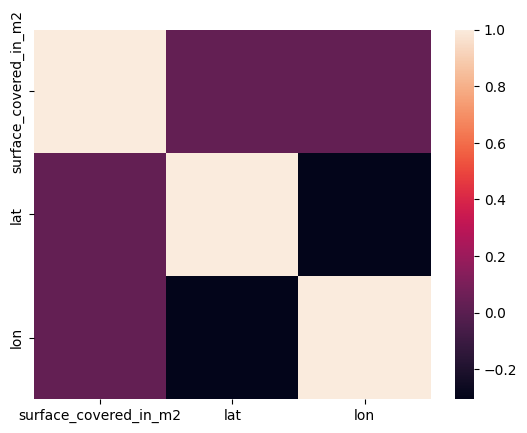

In [25]:
# corr = df.select_dtypes("number").head()  #Here we dropped our target because we are not interested in it at the moment
corr = df.select_dtypes("number").drop(columns="price_aprox_usd").corr()
corr

#using the newly created dataframe to create a heatmap
sns.heatmap(corr)

surface area and lat/lon have a pretty good correlation, although initially room had a very strong correlation with surface area but it was removed ensure model explainability.

#### **Splittin the Dataset for Training and Evaluation/Model building**

In [34]:
# Splitting the dataset for training and testing

# Defining Features and Target Variables
target = "price_aprox_usd"
y_train = df[target]
y_train.head()


features = ['surface_covered_in_m2', 'lat', 'lon', 'neighborhood']
X_train = df[features]
X_train.head()

,surface_covered_in_m2,lat,lon,neighborhood
0,70.0,-34.584651,-58.454693,Chacarita
1,42.0,-34.638979,-58.500115,Villa Luro
2,54.0,-34.615847,-58.459957,Caballito
3,42.0,-34.625222,-58.382382,Constitución
4,50.0,-34.610610,-58.412511,Once


In [35]:
# Split for evaluation
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, random_state=42)

the dataset has been split into train and test set which i used 80-20 ratio.

In [42]:
#Before building the model let me ensure that the categorical variable is encoded.

# Define feature types
num_features = ["surface_covered_in_m2", "lat", "lon"]
cat_features = ["neighborhood"]

# Imputer for numerical features
num_transformer = SimpleImputer(strategy="mean")

# Pipeline for categorical features using OneHotEncoder (drop first to avoid dummy trap)
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(use_cat_names=True))
])

# ColumnTransformer to handle both types
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_features),
        ("cat", cat_transformer, cat_features)
    ]
)


the neighborhood variable has been converted to binary for the model to be able to utilize it.

In [47]:
# Step 1: Impute missing neighborhood values (most frequent)
imputer = SimpleImputer(strategy='most_frequent')
X_neigh = imputer.fit_transform(X_train[['neighborhood']])
X_neigh = pd.DataFrame(X_neigh, columns=['neighborhood'])

# Step 2: Apply OneHotEncoder
encoder = OneHotEncoder(use_cat_names=True)
X_neigh_encoded = encoder.fit_transform(X_neigh)

# Step 3: Display the result
print(X_neigh_encoded.head())
print(f"Encoded columns: {X_neigh_encoded.head(5)}")


   neighborhood_Palermo  neighborhood_Mataderos  neighborhood_Villa Urquiza  \
0                     1                       0                           0   
1                     0                       1                           0   
2                     0                       0                           1   
3                     0                       0                           0   
4                     0                       0                           0   

   neighborhood_Nuñez  neighborhood_San Cristobal  neighborhood_San Nicolás  \
0                   0                           0                         0   
1                   0                           0                         0   
2                   0                           0                         0   
3                   1                           0                         0   
4                   0                           1                         0   

   neighborhood_Barrio Norte  neighborhood_Constit

To see what the encoding looks like, i had to print it so as we can see the neighborhood column now has binary representation which will make the model work effectively.

## **Building the Minimum Viable Model**

In [44]:
# Building the baseline model
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
print("Mean apt price:", round(y_mean, 2))

print("Baseline MAE:", mean_absolute_error(y_train, y_pred_baseline))

Mean apt price: 135047.17
Baseline MAE: 45453.264549750435


Here we look at the mean apartment price, and the baseline mean square error, and we have the values 135,047 dollars as the mean price for the values present in our dataset. Although our baseline model shows us a mean square error of 45,453 for the predicted value and we have 135,047 for the actual value. it means that we are just off 45,453 dollars for our prediction which is quite good.

In [48]:
# Creating the pipeline
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'),
    Ridge()
)

# Fitting the pipeline to the training data
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['neighborhood'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

So the pipeline has been created and we used OneHotEncoder, SimpleImputer and Ridge regression to minimize over fitting and underfitting.

In [49]:
# Calculating the training mean absolute error for predictions as compared to the true targets in y_train.
y_pred_training = model.predict(X_train)
print("Training MAE:", mean_absolute_error(y_train, y_pred_training))

Training MAE: 24637.3730817229


For the training dataset our prediction is 24,637 dollars which has reduced drastically and this shows that the model is predicting very well.

In [63]:
#Performing prediction
y_pred_test = model.predict(X_test)
print("Test MAE:", mean_absolute_error(y_test, y_pred_test))

Test MAE: 25249.517793152834


So feeding our model with the test dataset we can see that the mean square error is about 25k dollars as mentioned earlier this is good, but let us see other series for curiosity purpose.

In [64]:
# Predicting the price of the test dataset
y_pred_test = pd.Series(model.predict(X_test))
y_pred_test.head()

,0
0,177651.410554
1,264309.129987
2,126775.405921
3,171326.450534
4,213201.143776


this is great🤩 because if we look at the series provided we can see some predictions of roughly 17k approximately. although this is tested on the part of the dataset the model hasn't seen.

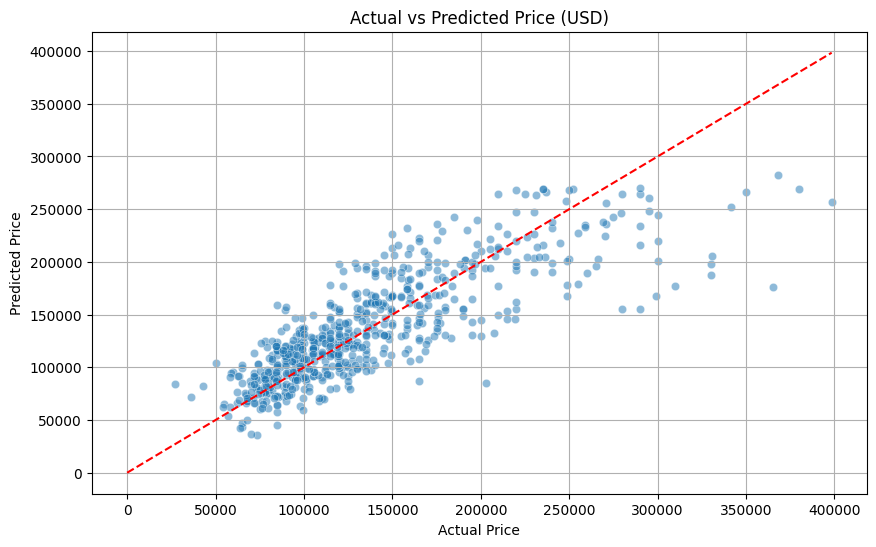

In [57]:
# Since our model performs accurately lets visualize this
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_test, alpha=0.5)
plt.plot([0, max(y_test)], [0, max(y_test)], color='red', linestyle='--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Price (USD)")
plt.grid(True)
plt.show()

As we can see, our model performs very well, the best fit line indicates that the model predicts almost accurately, although some data points appear to be far off which means that we have a few houses that are very expensive

In [53]:
# Testing the Model for prediction and providing positional arguments

def make_prediction(area, lat, lon, neighborhood):
    data ={
        "surface_covered_in_m2": area,
        "lat": lat,
        "lon": lon,
        "neighborhood": neighborhood
    }
    df= pd.DataFrame(data, index=[0])
    prediction = model.predict(df).round(2)[0]
    return f"Predicted apartment price: ${prediction}"

So this function takes in the parameters or arguments we have used, that is, our selected features because we are predicting based on size, location and neighborhood, and then the model will predict this and round the figures down to 2 significant places.

In [55]:
#Lets see that the model works
make_prediction(110, -34.60, -58.46, "Villa Crespo")

'Predicted apartment price: $259399.69'

so i selected a random parameter from the dataset and the predicted apartment price is about 259,399 dollars, this neighbourhood should be top notch cause the house is quite expensive.

In [56]:
# To communicate the result or allow users to view the output of this model i created an interactive dashboard
interact(
    make_prediction,
    area=IntSlider(
        min=X_train["surface_covered_in_m2"].min(),
        max=X_train["surface_covered_in_m2"].max(),
        value=X_train["surface_covered_in_m2"].mean(),
    ),
    lat=FloatSlider(
        min=X_train["lat"].min(),
        max=X_train["lat"].max(),
        step=0.01,
        value=X_train["lat"].mean(),
    ),
    lon=FloatSlider(
        min=X_train["lon"].min(),
        max=X_train["lon"].max(),
        step=0.01,
        value=X_train["lon"].mean(),
    ),
    neighborhood=Dropdown(options=sorted(X_train["neighborhood"].unique())),
);

interactive(children=(IntSlider(value=54, description='area', min=31), FloatSlider(value=-34.59840838515812, d…

So with the slider we can choose any apartment of our choice, in any area and as we see it here Agronomia neighborhood isnt as expensive as Villa Crepso, with the price of 128,655 dollars. i think i would rather buy here although it depends on how much money i have because we have different taste as humans. who knows i might actually buy in Villa Crepso after all.